In [5]:
#import modules
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from mpl_toolkits.mplot3d import Axes3D 
import tensorflow_probability as tfp
import timeit
import math as m
import pandas as pd

from HessianMCMC import HessianMCMC
from Grav_polygon import constant64,Gravity_Polygon
from GaussianProcess import GaussianProcess2Dlayer

tfb = tfp.bijectors
tfd = tfp.distributions
psd_kernels = tfp.math.psd_kernels

In [6]:

## define some numbers
Number_para = 5
obs_N = 10
number_burnin = 3000
number_sample = 10000
steps_gradient_decent = 2000

pi = constant64(m.pi) # define PI in Tensorflow form

depth = constant64(-100)
thickness = constant64(30)

Range = constant64([-200.,200.])

# prior
mu_prior = -50.*tf.ones([Number_para],dtype = tf.float64)
cov_prior = 15.*tf.eye(Number_para,dtype = tf.float64)

x_obv = tf.linspace(Range[0],Range[1],obs_N)

rho = 2000
# likelihood
sig_e = constant64(2*1e-8)
cov=sig_e ** 2.*tf.eye(obs_N,dtype = tf.float64)

model = Gravity_Polygon(obs_N, Range, rho, thickness, Number_para)

model.set_prior(mu_prior, cov_prior, cov)
model.depth = depth

## define the ground truth
tf.random.set_seed(8)

# X- values: uniformly distributed
control_index = tf.linspace(Range[0],Range[1],Number_para)
# control_index with non-even distribution
# control_index = tf.linspace(Range[0],Range[1],Number_para)+tf.random.uniform([Number_para],-20,20,dtype = tf.float64)

## define the true z-values

True_position_sin = 20*tf.sin(0.01*control_index)+depth


In [7]:

def simulated_gravity(x,z,x_obs=None,Number_=obs_N ,R=100,ax = None,style = None,**kwargs):
    """
    kwargs:
        x_obs: x coordinates of observation points
        Number_: number of observation points, if x_obs is not given
    return: 
        gravity: Tensor
    """
    if ax is None:
        f,ax=plt.subplots()
    if x_obs is None:
        x_obs = np.linspace(-R,R,Number_)
    y = np.zeros(np.shape(x_obs))
    obv = np.vstack((x_obs,y)).T

    gravity = model.calculate_gravity(x,z)
    if style is None:
        style = '-'
    ax.set_title('gravity response at surface')
    ax.set_ylabel('g_z ($m/s^2$ )')

    ax.set_xlim(-R,R)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
    ax.plot(x_obs,gravity,style,**kwargs)
    return gravity

def Draw_inter(_control_index,_control_position,x_ = None, z_ = None, z_true = None,R = 100, ax = None,**kwargs):
    if ax is None:
        _,ax = plt.subplots(figsize = (14,7))
    if z_true is not None:
        ## true poistion is black
        ax.scatter(control_index,z_true, c = 'black',label = 'true position',alpha = 0.6)
    
    if x_ is None:
        x_,z_ = gp.GaussianProcess(_control_index,_control_position)
    ax.plot(x_,z_,**kwargs)
    ## proposal is red
    ax.scatter(_control_index,_control_position, label = 'model position',c = 'red')

    ax.plot(np.linspace(-R,R,obs_N),np.zeros(obs_N))
    ax.plot(np.linspace(-R,R,obs_N),np.zeros(obs_N),'k|')
    ax.set_ylim(depth-100,10)
    ax.set_xlim(-R,R)
    
def Draw(_control_index,_control_position,_x = None,_z = None,true_position = None,ax = None,R =100,**kwargs):
    if ax is None:
        f,ax = plt.subplots(2,sharex=True, figsize = (7,10))
    if _x is None:
        _x,_z = gp.GaussianProcess(_control_index,_control_position,resolution=10)

    simulated_gravity(_x,_z,R = R,ax = ax[0],**kwargs)
    Draw_inter(_control_index,_control_position,x_ = _x, z_ = _z,R = R,ax = ax[1],z_true =true_position,**kwargs)
#     plt.legend(loc = 'lower right')
    
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(),loc = 'lower right')
    


In [8]:

# prior
mu_prior = True_position_sin
cov_prior = tf.constant([30**2,0.1,0.1,0.1,0.1],dtype = tf.float64)*tf.eye(Number_para,dtype = tf.float64)

x_obv = tf.linspace(Range[0],Range[1],obs_N)

rho = 2000
# likelihood
sig_e = constant64(2*1e-8)
cov=sig_e ** 2.*tf.eye(obs_N,dtype = tf.float64)


mvn_prior = tfd.MultivariateNormalTriL(
    loc=mu_prior,
    scale_tril=tf.linalg.cholesky(cov_prior))

control_index_ = tf.expand_dims(tf.linspace(Range[0], Range[1], Number_para), 1)

gp = GaussianProcess2Dlayer(Range,depth,Number_para,thickness,)
gp.amplitude =tfp.util.TransformedVariable(0.01, tfb.Exp(), dtype=tf.float64, name='amplitude')
gp.length_scale = tfp.util.TransformedVariable(
            100, tfb.Exp(), dtype=tf.float64, name='length_scale')
gp.kernel = psd_kernels.ExponentiatedQuadratic(
    gp.amplitude, gp.length_scale)
gp.observation_noise_variance = 0.

N = 1000

gravity_ = tf.TensorArray(tf.float64, size=N)

z_cord = tf.TensorArray(tf.float64, size=N)
for i in range(N):
    mu=mvn_prior.sample()
    if (mu.numpy() < 0).all():
        _x,_z = gp.GaussianProcess(control_index,mu,resolution=100)
        z_cord = z_cord.write(i,_z)
        gravity_ = gravity_.write(i,model.calculate_gravity(_x,_z))
    else: continue
x_cord = _x.numpy()

x_obv_p = np.expand_dims(x_obv, 1)

gravity = np.squeeze(gravity_.stack())
gravity_mean = np.mean(gravity,0)
gravity_std = np.std(gravity, 0)

G = gravity
Data_mean = np.mean(G, 0)

cov_matrix = np.cov(G.T)
# eigval,eigvec = np.linalg.eig(cov_matrix)

# new_cov = eigvec @ np.diag(eigval + 1e-28)@eigvec.T

## define oversample parameter number
Number_para_os = 30

# prior
mu_prior = -100.*tf.ones([Number_para_os],dtype = tf.float64)
cov_prior = 30.*tf.eye(Number_para_os,dtype = tf.float64)

# likelihood
Data = tf.convert_to_tensor(Data_mean)
# cov = tf.convert_to_tensor(new_cov, dtype=tf.float64)
cov = tf.convert_to_tensor(cov_matrix, dtype=tf.float64)

prior_x = np.expand_dims(np.linspace(Range[0],Range[1],Number_para_os),1)
mu_prior_y = np.expand_dims(mu_prior,1)
cov_prior_sigma = np.expand_dims(np.diag(cov_prior), 1)

control_index_os = tf.linspace(Range[0],Range[1],Number_para_os)

True_position_sin = 20*tf.sin(0.01*control_index_os)+depth

model1 = Gravity_Polygon(obs_N,Range,rho,thickness,Number_para_os)

model1.set_prior(mu_prior,cov_prior,cov)

mu_init = tf.random.normal([Number_para_os],mean = depth, stddev = 20,seed = 1,dtype = tf.float64) # initial parameters

gp = GaussianProcess2Dlayer(Range,depth,Number_para,thickness,)
gp.amplitude =tfp.util.TransformedVariable(0.01, tfb.Exp(), dtype=tf.float64, name='amplitude')
gp.length_scale = tfp.util.TransformedVariable(
            40, tfb.Exp(), dtype=tf.float64, name='length_scale')
gp.kernel = psd_kernels.ExponentiatedQuadratic(
    gp.amplitude, gp.length_scale)
gp.observation_noise_variance = 0.
gp.Number_para = Number_para_os

model1.gp = gp



steps_gradient_decent = 100
lost = []
mu = mu_init
for i in range(steps_gradient_decent):
    with tf.GradientTape() as t:  
        t.watch(mu)
        loss = model1.negative_log_posterior(Data,mu) # negative log posterior
        lost.append(loss.numpy())
    dlossdmu = t.gradient(loss,mu)
    mu = mu-tf.multiply(constant64(1e-4),dlossdmu)
    

gp.Number_para=Number_para_os

MAP=mu

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/zhouji/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3345, in run_code
    return outflag  File "<ipython-input-4-d9106a57cc3e>", line 35, in <module>
    _x,_z = gp.GaussianProcess(control_index,mu,resolution=100)  File "/Users/zhouji/.local/lib/python3.7/site-packages/tensorflow/python/util/tf_should_use.py", line 237, in wrapped
    error_in_function=error_in_function)
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/zhouji/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3345, in r

In [9]:
loss

<tf.Tensor: shape=(), dtype=float64, numpy=23912.535501901086>

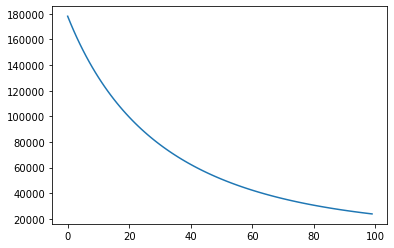

In [12]:
plt.plot(lost[:])

In [27]:
def Full_Hessian():
    Hess = tf.TensorArray(tf.float64, size=Number_para_os)
    for i in range(Number_para_os):
        with tf.GradientTape() as t:
            t.watch(MAP)
            with tf.GradientTape(persistent=True) as tt:
                tt.watch(MAP)
                loss = model1.negative_log_posterior(Data,MAP)
            jac = tt.gradient(loss,MAP,unconnected_gradients='zero')[i]
        hess = t.gradient(jac,MAP,unconnected_gradients = 'none')
        Hess = Hess.write(i,hess)
    return Hess.stack()
start = timeit.default_timer()
New_Hessian = Full_Hessian()
end = timeit.default_timer()
print('time for Hessian calculation: %.3f' % (end - start))


time for Hessian calculation: 0.407


In [26]:
New_Hessian

<tf.Tensor: shape=(30, 30), dtype=float64, numpy=
array([[ 2.40096154e+01,  1.44458491e+01,  2.41084481e+00,
        -8.73799229e+00, -1.56222414e+01, -1.68885373e+01,
        -1.35942106e+01, -7.83278850e+00, -1.40669274e+00,
         4.34287197e+00,  8.27922918e+00,  9.71205520e+00,
         8.90609353e+00,  7.10451382e+00,  5.72475297e+00,
         5.00555429e+00,  3.23321377e+00, -1.91990789e+00,
        -1.02320172e+01, -1.73054294e+01, -1.75314860e+01,
        -9.57843656e+00,  1.53850014e+00,  8.51665177e+00,
         7.84466971e+00,  1.85531314e+00, -4.49095190e+00,
        -8.10081809e+00, -9.29820822e+00, -9.92724585e+00],
       [ 1.44458491e+01,  1.00426678e+01,  2.81621888e+00,
        -4.53565381e+00, -9.05155283e+00, -9.64788802e+00,
        -7.41876889e+00, -4.02354612e+00, -4.50178927e-01,
         2.77003443e+00,  4.99041086e+00,  5.65079050e+00,
         4.89147853e+00,  3.62922979e+00,  2.85086462e+00,
         2.64735607e+00,  1.84976115e+00, -1.00528329e+00,
     

In [24]:
tangents=tf.constant([1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],dtype = tf.float64)
tangents.shape

TensorShape([30])

In [25]:
with tf.autodiff.ForwardAccumulator(MAP, tangents) as acc:
    with tf.GradientTape(persistent=True) as tt:
        tt.watch(MAP)
        loss = model1.negative_log_posterior(Data,MAP)
    jac = tt.gradient(loss,MAP,unconnected_gradients='zero')
print(acc.jvp(jac))

tf.Tensor(
[ 24.00961537  14.44584906   2.41084481  -8.73799229 -15.62224144
 -16.88853725 -13.59421056  -7.8327885   -1.40669274   4.34287197
   8.27922918   9.7120552    8.90609353   7.10451382   5.72475297
   5.00555429   3.23321377  -1.91990789 -10.23201718 -17.30542942
 -17.53148601  -9.57843656   1.53850014   8.51665177   7.84466971
   1.85531314  -4.4909519   -8.10081809  -9.29820822  -9.92724585], shape=(30,), dtype=float64)


/Users/zhouji/anaconda3/envs/nightly/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:333: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


Random walk time in seconds: 66.461
Acceptance rate = 0.49%


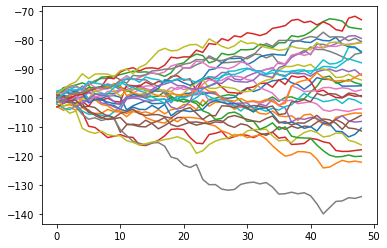

In [6]:
### MCMC RNH

number_sample=10000
number_burnin = 0

num_results = number_sample
burnin = number_burnin


initial_chain_state = [
    depth * tf.ones([Number_para_os], dtype=tf.float64, name="init_t1"),
]

unnormalized_posterior_log_prob = lambda *args: model1.joint_log_post(Data,*args)

def gauss_new_state_fn(scale, dtype):
    gauss = tfd.Normal(loc=dtype(0), scale=dtype(scale))
    def _fn(state_parts, seed):
        next_state_parts = []
        seed_stream  = tfp.util.SeedStream(seed, salt='RandomNormal')
        for sp in state_parts:
            next_state_parts.append(sp + gauss.sample(
            sample_shape=sp.shape, seed=seed_stream()))
        return next_state_parts
    return _fn

dtype = np.float64
start = timeit.default_timer()
samples, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    current_state=initial_chain_state,
    kernel=tfp.mcmc.RandomWalkMetropolis(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        new_state_fn=gauss_new_state_fn(scale=1, dtype=dtype)),
    num_burnin_steps=burnin,
    num_steps_between_results=1,  # Thinning.
    parallel_iterations=1)
end = timeit.default_timer()
print('Random walk time in seconds: %.3f' % (end - start))

samples = tf.stack(samples, axis=-1)
accepted = kernel_results.is_accepted

samples = samples.numpy()
accepted = accepted.numpy()

accept_index = np.where(accepted==True)
accepted_samples_RMH = samples[accept_index]
accepted_samples_RMH = np.squeeze(accepted_samples_RMH)

print('Acceptance rate = %0.2f%%' % (100*accepted_samples_RMH.shape[0]/number_sample) )

# pd.DataFrame(accepted_samples_RMH).to_csv('./RMH.txt')

plt.plot(accepted_samples_RMH[:,:])

/Users/zhouji/anaconda3/envs/nightly/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:333: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


Random walk time in seconds: 211.213
Acceptance rate = 6.62%


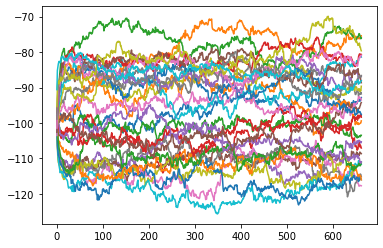

In [10]:
### HMC
number_sample=10000
number_burnin = 0

@tf.function
def run_HMC():
    samples, kernel_results = tfp.mcmc.sample_chain(
        num_results=number_sample,
        current_state=initial_chain_state,
        kernel=tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=unnormalized_posterior_log_prob,
            step_size = 0.08,
            num_leapfrog_steps = 3),
        num_burnin_steps=number_burnin,
        num_steps_between_results=5,  # Thinning.
        parallel_iterations=1)
    return samples,kernel_results

start = timeit.default_timer()

samples,kernel_results = run_HMC()

end = timeit.default_timer()
print('Random walk time in seconds: %.3f' % (end - start))

samples = tf.stack(samples, axis=-1)
accepted = kernel_results.is_accepted

samples = samples.numpy()
accepted = accepted.numpy()

accept_index = np.where(accepted==True)
accepted_samples_HMC = samples[accept_index]
accepted_samples_HMC = np.squeeze(accepted_samples_HMC)

print('Acceptance rate = %0.2f%%' % (100*accepted_samples_HMC.shape[0]/number_sample) )
# pd.DataFrame(accepted_samples_RMH).to_csv('./HMC.txt')

plt.plot(accepted_samples_HMC[:,:])

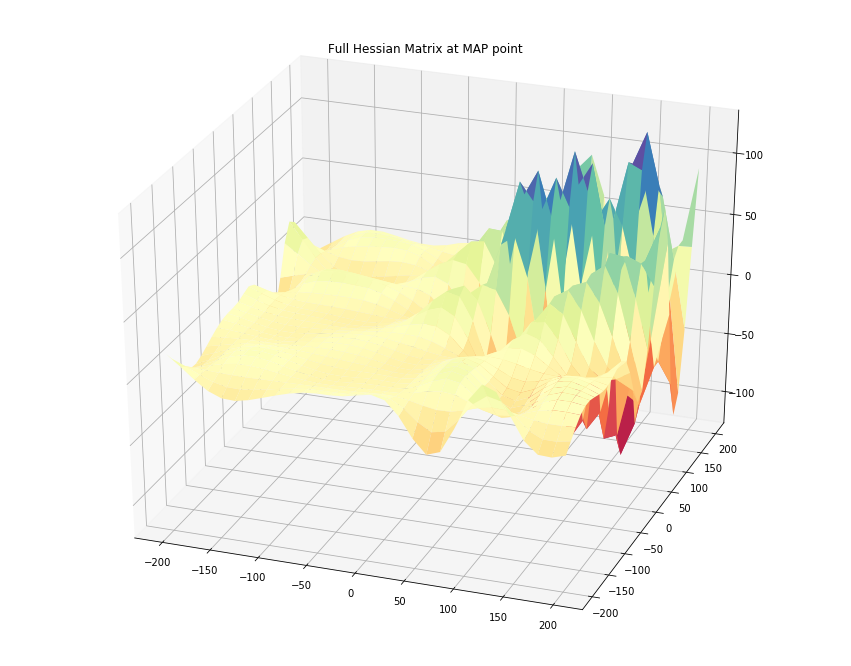

In [28]:
fig = plt.figure(figsize = (15,12))
ax = fig.gca(projection='3d')

X = np.linspace(-200,200,New_Hessian.shape[0])
Y = np.linspace(-200,200,New_Hessian.shape[0])
X, Y = np.meshgrid(X, Y)

surf = ax.plot_surface(X, Y, New_Hessian, cmap=plt.cm.Spectral,
                       linewidth=0, antialiased=True)
ax.view_init(30, 290)
ax.set_title('Full Hessian Matrix at MAP point')
# plt.savefig("/Users/zhouji/Documents/Presentations/EGU 2020/Presentation/Hessian3Dview.png")

In [74]:
### gpCN
beta = constant64(0.9)
number_sample = 10000
number_burnin = 0
h = HessianMCMC(Number_para_os,model1.negative_log_posterior,
                Data,MAP,cov_prior,number_sample,number_burnin,mu_init = MAP,beta = beta)
h.Full_Hessian()

accepted_samples_gpCN, rejected_samples_gpCN = h.run_chain_hessian(New_Hessian)
accepted_samples_gpCN = np.array(accepted_samples_gpCN)
print('Acceptance rate = %0.2f%%' % (100 * accepted_samples_gpCN.shape[0] / number_sample))

Acceptance rate = 1.63%


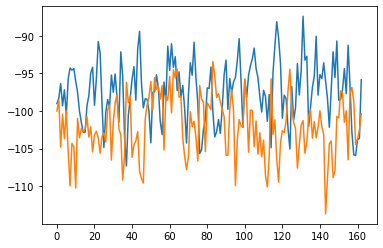

In [75]:
plt.plot(accepted_samples_gpCN[:,1:3])

In [71]:
MAP

<tf.Tensor: shape=(30,), dtype=float64, numpy=
array([ -95.5158189 ,  -98.4448463 , -102.79326106, -104.07730531,
       -109.35955095, -111.12504524, -112.57471962, -114.28400614,
       -114.75221188, -114.0565574 , -114.33180286, -112.74831054,
       -109.84488462, -106.87758373, -102.88164678,  -97.58872447,
        -93.69636505,  -92.51773437,  -90.37793957,  -87.7227376 ,
        -84.69958768,  -81.45702572,  -81.30726616,  -80.45321074,
        -82.29639868,  -84.75379899,  -84.88507551,  -86.31177016,
        -84.33776917,  -83.11935819])>

In [77]:
model1.negative_log_posterior(Data,MAP)

<tf.Tensor: shape=(), dtype=float64, numpy=-23.47275555606066>